In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [2]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [3]:
# Dataset; 'iggin' or 'iggielgn'
dataset = 'iggielgn'

# S-t-flow; 's-t-degree' or 's-t-type'
s_t_flow = 'hybrid'

# Analysis; 'centrality' or 'max_flow'
analysis = 'centrality'

metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'


In [4]:
node_removals_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
if analysis == 'centrality':
    node_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_node_removal.pkl').head(100)

# NODE: Network Impact Heatmap

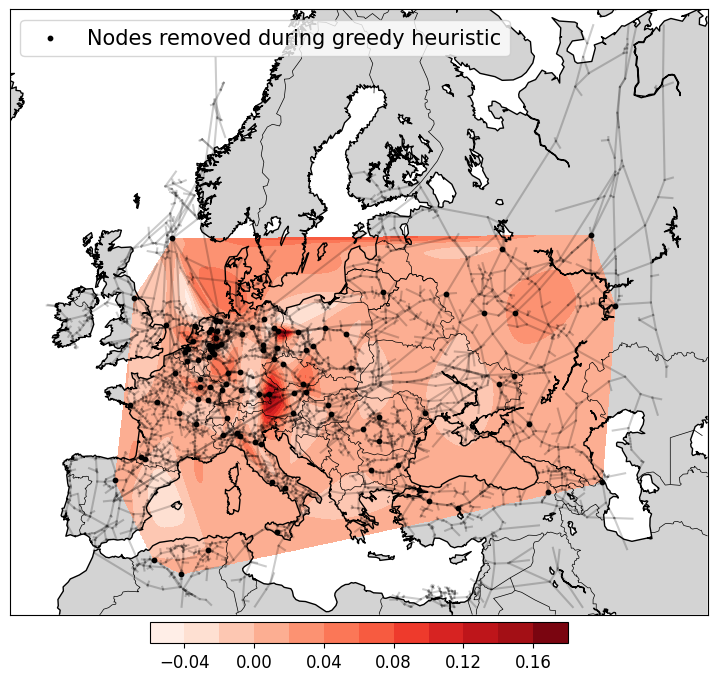

In [6]:
df = node_removals_df.copy()
df[metric+'_diff'] = df[metric].diff().abs()

# Get the latitude and longitude of nodes present in the DataFrame
df = df.iloc[1:]

nodes_in_df = df['removed_entity'].values
lats = [G_simple_directed.nodes[node]['lat'] for node in nodes_in_df if node in G_simple_directed.nodes()]
lons = [G_simple_directed.nodes[node]['long'] for node in nodes_in_df if node in G_simple_directed.nodes()]

# Create a grid for interpolation
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)
num_points = 500
lons_interp = np.linspace(lon_min, lon_max, num_points)
lats_interp = np.linspace(lat_min, lat_max, num_points)
lons_mesh, lats_mesh = np.meshgrid(lons_interp, lats_interp)

# Convert the latitude and longitude of nodes in the DataFrame to numpy array
points = np.array(list(zip(lons, lats)))

# Remove NaN values from the values array
values = df[metric+'_diff'].values
mask = ~np.isnan(values)
values = values[mask]
points = points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='cubic')

plt.figure(figsize=(9, 10)) 

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the interpolated heatmap
x_interp, y_interp = m(lons_mesh, lats_mesh)
sc = m.contourf(x_interp, y_interp, metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', shrink=0.6, aspect=20, pad=0.01)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=12)

# cbar.set_label('Damage to '+metric, fontsize=12)
# if analysis == 'max_flow':
#    cbar.set_label('Damage to FCR', fontsize=12)


# Plot the points themselves
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=10, label='Nodes removed during greedy heuristic') 


# Plot the all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=15)  

plt.savefig('saved_plots/heatmaps/'+analysis+'/node_impact.png', bbox_inches='tight', pad_inches=0)

plt.show()


# Network Zone Heatmap
Heat based on the order in which the nodes were removed, to identify critical zones based on priority

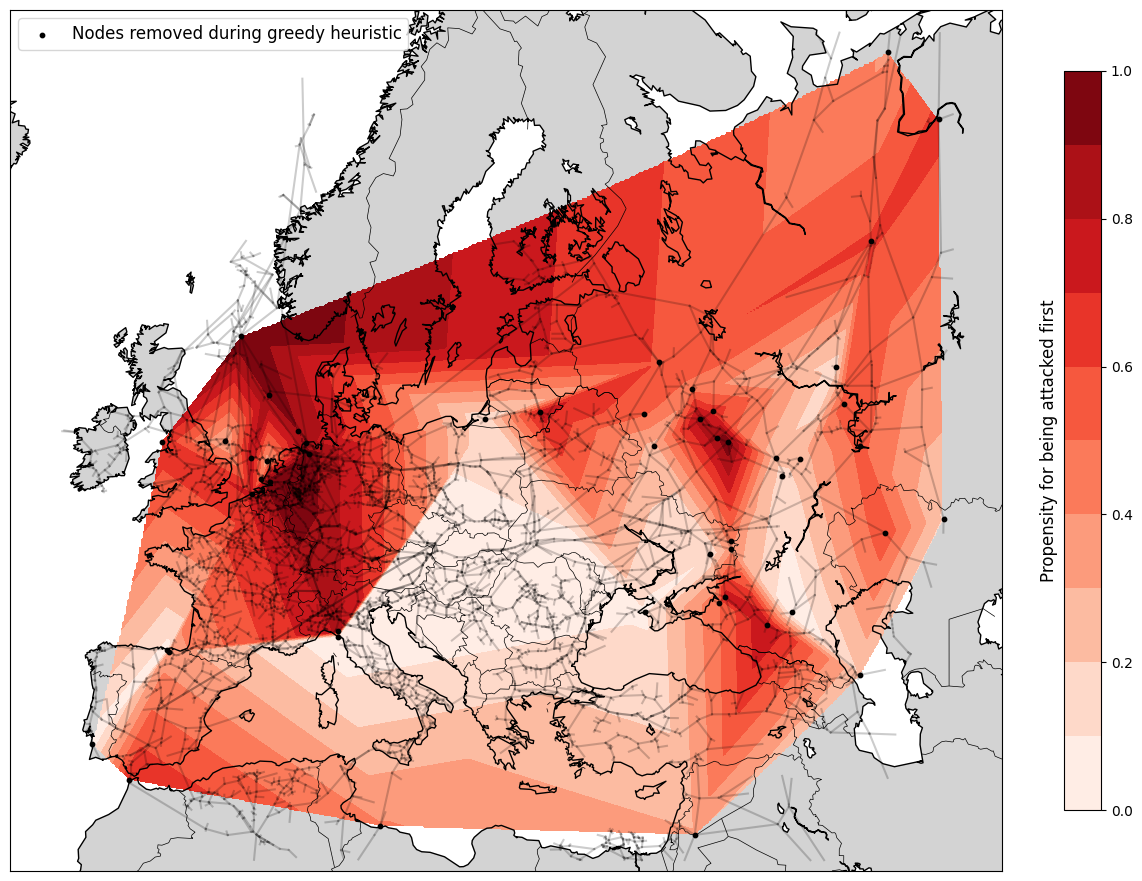

In [7]:
""" # Create a new column in df that assigns an important metric to each 'removed_entity' based on how early it was removed (i.e., index)
df = node_removals_df.copy().iloc[1:]
df['importance'] = df.index.values
df['importance'] = df['importance'].max() - df['importance']
df['importance'] = df['importance']/df['importance'].max()

values = df['importance'].values
mask = ~np.isnan(values)
values, points = values[mask], points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='linear')

plt.figure(figsize=(16, 16))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgrey')

# Plot the interpolated heatmap
sc = m.contourf(*m(lons_mesh, lats_mesh), metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.6, aspect=20)
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('Propensity for being attacked first', fontsize=12)

# Plot the points themselves
m.scatter(*m(lons, lats), c='black', marker='o', s=10, label='Nodes removed during greedy heuristic')  


# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    m.plot(*m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']]), 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=12)  

plt.savefig('saved_plots/heatmaps/'+analysis+'/node_zone.png', bbox_inches='tight', pad_inches=0)

plt.show()
 """

# EDGE: Flow Subgraph Map

In [48]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [49]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [50]:
# Analysis; 'centrality' or 'max_flow'
analysis = 'centrality'

In [51]:
metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'

edge_removals_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/wfcr_edge_removal_df.pkl')
if analysis == 'centrality':
    edge_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_edge_removal.pkl').head(100)

In [52]:
edge_removals_df

,iteration,removed_entity,NPI,connectedness,reach,connectivity,heuristic
0,0.0,NaN,1.000000,1.000000,1.000000,1.000000,NaN
1,1.0,"{LKD_N_148, LKD_N_158}",0.948296,0.991249,1.000000,0.956669,greedy
2,2.0,"{SEQ_10405__S_LMGN, N_161_L_LMGN}",0.807236,0.988078,1.000000,0.816976,greedy
3,3.0,"{N_730_M_LMGN, N_731_M_LMGN}",0.714520,0.973639,1.000000,0.733866,greedy
4,4.0,"{SEQ_5193__L_LMGN, SEQ_5183__L_LMGN}",0.598821,0.964793,1.000000,0.620674,greedy
...,...,...,...,...,...,...,...
95,95.0,"{SEQ_8179__M_LMGN, SEQ_8173__M_LMGN}",0.110477,0.851416,0.874195,0.148430,greedy
96,96.0,"{SEQ_4451__L_LMGN, SEQ_4441__L_LMGN}",0.106048,0.851416,0.846181,0.147196,greedy
97,97.0,"{N_596_S_LMGN, N_822_S_LMGN}",0.105117,0.850138,0.846181,0.146123,greedy
98,98.0,"{SEQ_11702_p, LKD_N_521}",0.104429,0.849075,0.846181,0.145349,greedy


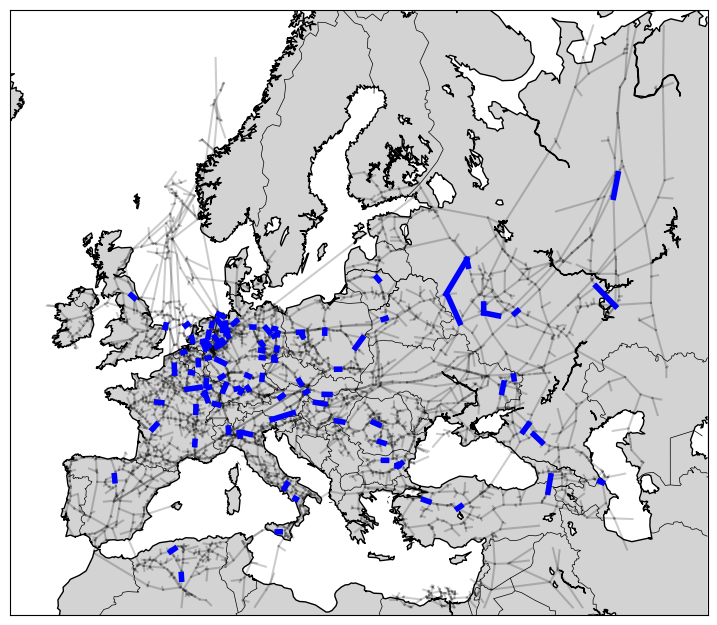

In [53]:
# Plot all the edges of G_simple_directed on a map of Europe
plt.figure(figsize=(9, 10))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)

# Plot the points themselves
edge_removals_df = edge_removals_df.iloc[1:]
for edge in edge_removals_df['removed_entity'].values:
    edge = tuple(edge)
    u, v = edge
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'b-', linewidth=4)

plt.savefig('saved_plots/heatmaps/'+analysis+'/edge_impact.png', bbox_inches='tight', pad_inches=0)

plt.show()
